## 2025-07-29 Comparison of figures of merit for model selection in MCMC ##

Uses the **arviz** library to compute figure of merit (WAIC and LOO) for MCMC runs (in this case produced by **emcee** and plots the run of figure of merit vs fit degree (i.e. degree of the polynomial used). Note that the generating and fit model also includes outliers - this is MCMC on a mixture model as covered in Dan Foreman-Mackey's brilliant 2014 post (see here: [10.5281/zenodo.15856](http://dx.doi.org/10.5281/zenodo.15856)).

**emcee** samplers are run and dumped to pickle files in the accompanying notebook **2025-07-29_emcee_1d_mixmod_example-withloops.ipynb** - that notebook produces a run of explorations of the same dataset, e.g. in this example there would be a set of files sampler_ndata40_seed132546_outly2.0_gen2_fit?.pickle . These are read in here, imported to arviz inference objects, and the WAIC and LOO computed for each and compared.

Here the filenames for the .pickle sampler files serve as metadata: in particular the number of datapoints, the degree used to generate the data, and the random number seed are read in from the filename. That filename was generated in the generating notebook so it should be easy to make more examples that stay consistent.


In [1]:
import glob
import numpy as np
import arviz as az
import pickle
import matplotlib.pylab as plt

In [2]:
# !ls -rtlh *pickle

In [3]:
# list of sampler files for this clump of simulations
# lfiles = glob.glob('sampler_ndata40_seed132546_outly2.0_gen2_fit?.pickle')
lfiles = glob.glob('sampler_ndata40_seed12_outly2.0_gen2_fit?.pickle')

In [4]:
# construct filename for plot, plot title, out of the first path name
pathplot = 'foms_%s.png' % (lfiles[0].split('_fit')[0].split('sampler_')[-1])
ndata = lfiles[0].split('ndata')[-1].split('_')[0]
seed = lfiles[0].split('seed')[-1].split('_')[0]
deggen = lfiles[0].split('gen')[-1].split('_')[0]
plottitl = 'gen %s, ndata %s, seed %s' % (deggen, ndata, seed)

print(pathplot, plottitl)

foms_ndata40_seed12_outly2.0_gen2.png gen 2, ndata 40, seed 12


In [5]:
lfiles

['sampler_ndata40_seed12_outly2.0_gen2_fit6.pickle',
 'sampler_ndata40_seed12_outly2.0_gen2_fit4.pickle',
 'sampler_ndata40_seed12_outly2.0_gen2_fit0.pickle',
 'sampler_ndata40_seed12_outly2.0_gen2_fit2.pickle',
 'sampler_ndata40_seed12_outly2.0_gen2_fit5.pickle',
 'sampler_ndata40_seed12_outly2.0_gen2_fit1.pickle',
 'sampler_ndata40_seed12_outly2.0_gen2_fit3.pickle']

In [6]:
# glob doesn't necessarily return the files in numerical order...
degs = []
for path in lfiles:
    sdeg = path.split('.pickle')[0].split('fit')[-1]
    ideg = int(sdeg)
    degs.append(ideg)
    
lsor = np.argsort(degs)
print(lsor)

[2 5 3 6 1 4 0]


In [7]:
# put function definitions in memory so we can load them
# Define the probabilistic model...
# A simple prior:
# bounds = [(0.1, 1.9), (-0.9, 0.9), (0, 1), (-2.4, 2.4), (-7.2, 5.2)]


def lnprior(p):
    # We'll just put reasonable uniform priors on all the parameters.
    if not all(b[0] < v < b[1] for v, b in zip(p, bounds)):
        return -np.inf
    return 0


# The "foreground" linear likelihood:
def lnlike_fg(p):
    #m, b, _, M, lnV = p
    #model = m * x + b
    
    # polynomial parameters unpacked programmatically
    M, lnV = p[-2::]
    ppoly = p[0:-3]

    model = np.polyval(ppoly,x)
    
    return -0.5 * (((model - y) / yerr) ** 2 + 2 * np.log(yerr))


# The "background" outlier likelihood - where data itself is generated from a gaussian:
def lnlike_bg(p):
    #_, _, Q, M, lnV = p
    
    # unpack the nuisance parameters
    Q, M, lnV = p[-3::]
    
    var = np.exp(lnV) + yerr**2
    return -0.5 * ((M - y) ** 2 / var + np.log(var))

def lnlike_bg_new(p):
    #m, b, Q, M, lnV = p
    #model = m * x + b + M
    
    Q, M, lnV = p[-3::]
    
    ppoly = p[0:-3]
    model = np.polyval(ppoly, x)
    
    var = np.exp(lnV) + yerr**2
    return -0.5 * ((model - y) ** 2 / var + np.log(var))



# Full probabilistic model.
def lnprob(p):
    #m, b, Q, M, lnV = p

    # I think we only need the Q value here, the rest of the 
    # parameters get passed straight through.
    Q = p[-3]
    
    # First check the prior.
    lp = lnprior(p)
    if not np.isfinite(lp):
        return -np.inf, np.zeros_like(y), np.zeros_like(y), np.repeat(-np.inf, np.size(y))

    # Compute the vector of foreground likelihoods and include the q prior.
    ll_fg = lnlike_fg(p)
    arg1 = ll_fg + np.log(Q)

    # Compute the vector of background likelihoods and include the q prior.
    ll_bg = lnlike_bg(p)
    arg2 = ll_bg + np.log(1.0 - Q)

    # Combine these using log-add-exp for numerical stability.
    ll = np.sum(np.logaddexp(arg1, arg2))

    # We're using emcee's "blobs" feature in order to keep track of the
    # foreground and background likelihoods for reasons that will become
    # clear soon. 
    #
    # WIC - return log_likelihood too so we can feed it to arviz?
    return lp + ll, arg1, arg2, np.logaddexp(arg1, arg2)



In [8]:
# list of arviz objects
idatas = []

In [9]:
# now we have the samples in increasing order of degree, read them in  that way
for iorder in range(len(lsor)):
    thispath = lfiles[lsor[iorder]]
    print(iorder, thispath, lsor[iorder])
    sampler = pickle.load(open(thispath,'rb'))
    idatas.append(az.from_emcee(sampler, blob_names=["lnl", "lnprior", "lnlvec"]))

0 sampler_ndata40_seed12_outly2.0_gen2_fit0.pickle 2
1 sampler_ndata40_seed12_outly2.0_gen2_fit1.pickle 5
2 sampler_ndata40_seed12_outly2.0_gen2_fit2.pickle 3
3 sampler_ndata40_seed12_outly2.0_gen2_fit3.pickle 6
4 sampler_ndata40_seed12_outly2.0_gen2_fit4.pickle 1
5 sampler_ndata40_seed12_outly2.0_gen2_fit5.pickle 4
6 sampler_ndata40_seed12_outly2.0_gen2_fit6.pickle 0


In [10]:
# try interrogating this

# waic and loo variables
waics = np.zeros(len(idatas))
loos = np.copy(waics)

for iorder in range(len(idatas)):
    thiswaic = az.waic(idatas[iorder], var_name="lnlvec")
    thisloo = az.loo(idatas[iorder], var_name="lnlvec")
    
    waics[iorder] = thiswaic.waic
    loos[iorder] = thisloo.loo
    
    print("WAIC: %i, %.2f, %.2f, LOO: %.2f %.2f" % \
          (iorder, thiswaic.waic, thiswaic.waic_se, thisloo.loo, thisloo.loo_se))

/Users/wiclarks/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:1468: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:913: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


WAIC: 0, -29.41, 5.28, LOO: -29.45 5.30


/Users/wiclarks/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:1468: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:913: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


WAIC: 1, -8.74, 6.78, LOO: -8.96 6.87


/Users/wiclarks/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:1468: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:913: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


WAIC: 2, 16.89, 8.96, LOO: 16.79 8.99


/Users/wiclarks/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:1468: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:913: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:693: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importa

WAIC: 3, 8.15, 8.16, LOO: 6.21 8.28


/Users/wiclarks/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:913: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:693: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:1468: UserW

WAIC: 4, 9.22, 8.33, LOO: 8.40 8.42


/Users/wiclarks/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:913: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:693: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:1468: UserW

WAIC: 5, 15.09, 8.85, LOO: 14.21 8.92


/Users/wiclarks/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:913: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


WAIC: 6, 14.69, 8.79, LOO: 13.97 8.83


/Users/wiclarks/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:693: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


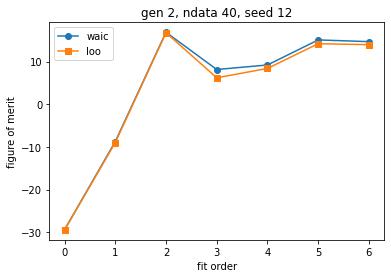

In [11]:
# let's take a look
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(111)
ax1.plot(waics, label='waic', marker='o')
ax1.plot(loos, label='loo', marker='s')
ax1.legend()
ax1.set_xlabel('fit order')
ax1.set_ylabel('figure of merit')
ax1.set_title(plottitl)
fig1.savefig(pathplot)
# ax1.set_ylim(bottom=10)